In [1]:
import sys
sys.path.insert(0, '/Users/Daniel/Documents/Imperial/MSciProject/BOUT-dev/tools/pylib/')

In [2]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boututils.showdata import showdata
from boutdata.data import BoutOptionsFile
from bout_runners import basic_runner
import numpy as np
import matplotlib.pyplot as plt
from  IPython.display import HTML
import seaborn as sns
import os 
import scipy.constants as constants
import scipy.stats as stats
import pandas as pd
from sklearn.linear_model import RANSACRegressor

from matplotlib import rc, animation
%matplotlib inline
rc('animation', html='html5') 

In [3]:
sns.set_style("white")
plt.style.use("thesis")
pal = sns.color_palette("Paired")

In [4]:
c = constants.c
m_i = 1e6*constants.physical_constants['proton mass energy equivalent in MeV'][0]/c**2
e = constants.e

inp = BoutOptionsFile("./BOUT.inp") 

kappa_0, T_t, n_t = (inp['step']['kappa_0'], inp['step']['T_t'], inp['step']['n_t'])

L = inp['mesh']['length']
dy = L/inp['mesh']['ny']
dt = inp['timestep']

In [5]:
bt = basic_runner(prog_name="../../Step/step", 
                  directory="./",
                  ny=400,             
                  additional = (('Step','heat_type', (0,2)),
                                ('Step','T_t', (20, )),
                                ('Step','a', (1, )),
                                ('T','k', np.floor(np.logspace(0, 2, 10)) )))



getmpirun: using the default mpirun -np


In [6]:
def get_variables(paths, ret):
    for p in paths:
        df = DataFile(os.path.join(p, "BOUT.dmp.0.nc"))
        y = collect("ypos", path=p, yguards=False, info=False)[0,:,0]
        T = collect("T", path=p, yguards=False, info=False)[:,0,:,0]
        v = collect("v", path=p, yguards=False, info=False)[:,0,:,0]
        n = collect("n", path=p, yguards=False, info=False)[:,0,:,0]
        ret.append((y,T,v,n))
        
def teq(k):
    if k <= 10:
        return 250
    elif k <= 20:
        return 50
    else:
        return 10
    
def plot_gamma(paths, ret):
    for p in paths:
               
        df = DataFile(os.path.join(p, "BOUT.dmp.0.nc"))
        y = collect("ypos", path=p, yguards=False, info=False)[0,:,0]
        T = collect("T", path=p, yguards=False, info=False)[:,0,:,0]
        l_e = np.mean(collect("lambda", path=p, yguards=False, info=False)[-1,0,:,0])
        l0 = np.mean(collect("lambda_0", path=p, yguards=False, info=False)[-1,0,:,0])

        opts = BoutOptionsFile(p + "/BOUT.settings")
        T_t = df['T_t']
        n_y = df['ny']
        
        t = dt*np.arange(0,teq(opts['T']['k']*l0))
        log_dT = np.log(np.abs(T[:teq(opts['T']['k']*l0), int(0.5*n_y-25):int(0.5*n_y+25)] - T_t)) -  np.log(np.abs(T[0, int(0.5*n_y-25):int(0.5*n_y+25)] - T_t))
        l = RANSACRegressor()
        gammas = np.array([-l.fit(t.reshape(-1, 1), log_dT[:,i:(i+1)]).estimator_.coef_[0,0] for i in range(50)])        
        
        ret.append((opts['T']['k'], l0, l_e, opts['step']['T_t'], 
                    opts['step']['heat_type'], 
                    np.nanmean(gammas), np.nanstd(gammas)))
        
        plt.plot(t, log_dT, marker='.')
        plt.xlabel("t")
        plt.ylabel(r"$\log(\delta T)$")
        plt.savefig(p+ "/decay.pdf")
        plt.close()
                   
        sns.distplot(gammas, kde=False, norm_hist=False)
        plt.savefig(p+ "/gammas.pdf")
        plt.close()
        

In [7]:
ret = []
paths, _ = bt.execute_runs(post_processing_function=plot_gamma, 
                           remove_old=False, 
                           post_process_after_every_run=False, 
                           ret=ret)


Running with inputs from './'

Checking the grid split for the meshes

Checking nx=1  and ny=400
Successfully found the following good values for the mesh:
nx = 1 ny = 400 


Now running:
./ny_400/Step_T_t_20_Step_a_1_Step_heat_type_0_T_k_1.0 created

mpirun -np 1 ./../../Step/step -d ./ny_400/Step_T_t_20_Step_a_1_Step_heat_type_0_T_k_1.0 mesh:ny=400 Step:heat_type=0 Step:T_t=20 Step:a=1 T:k=1.0


Skipping the run as *.dmp.* files was found in ./ny_400/Step_T_t_20_Step_a_1_Step_heat_type_0_T_k_1.0
To overwrite old files, run with self.execute_runs(remove_old=True)

./ny_400/Step_T_t_20_Step_a_1_Step_heat_type_0_T_k_2.0 created

mpirun -np 1 ./../../Step/step -d ./ny_400/Step_T_t_20_Step_a_1_Step_heat_type_0_T_k_2.0 mesh:ny=400 Step:heat_type=0 Step:T_t=20 Step:a=1 T:k=2.0


./ny_400/Step_T_t_20_Step_a_1_Step_heat_type_0_T_k_4.0 created

mpirun -np 1 ./../../Step/step -d ./ny_400/Step_T_t_20_Step_a_1_Step_heat_type_0_T_k_4.0 mesh:ny=400 Step:heat_type=0 Step:T_t=20 Step:a=1 T:k=4.0


.

/usr/local/lib/python3.5/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)
/usr/local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/usr/local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/usr/local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, a

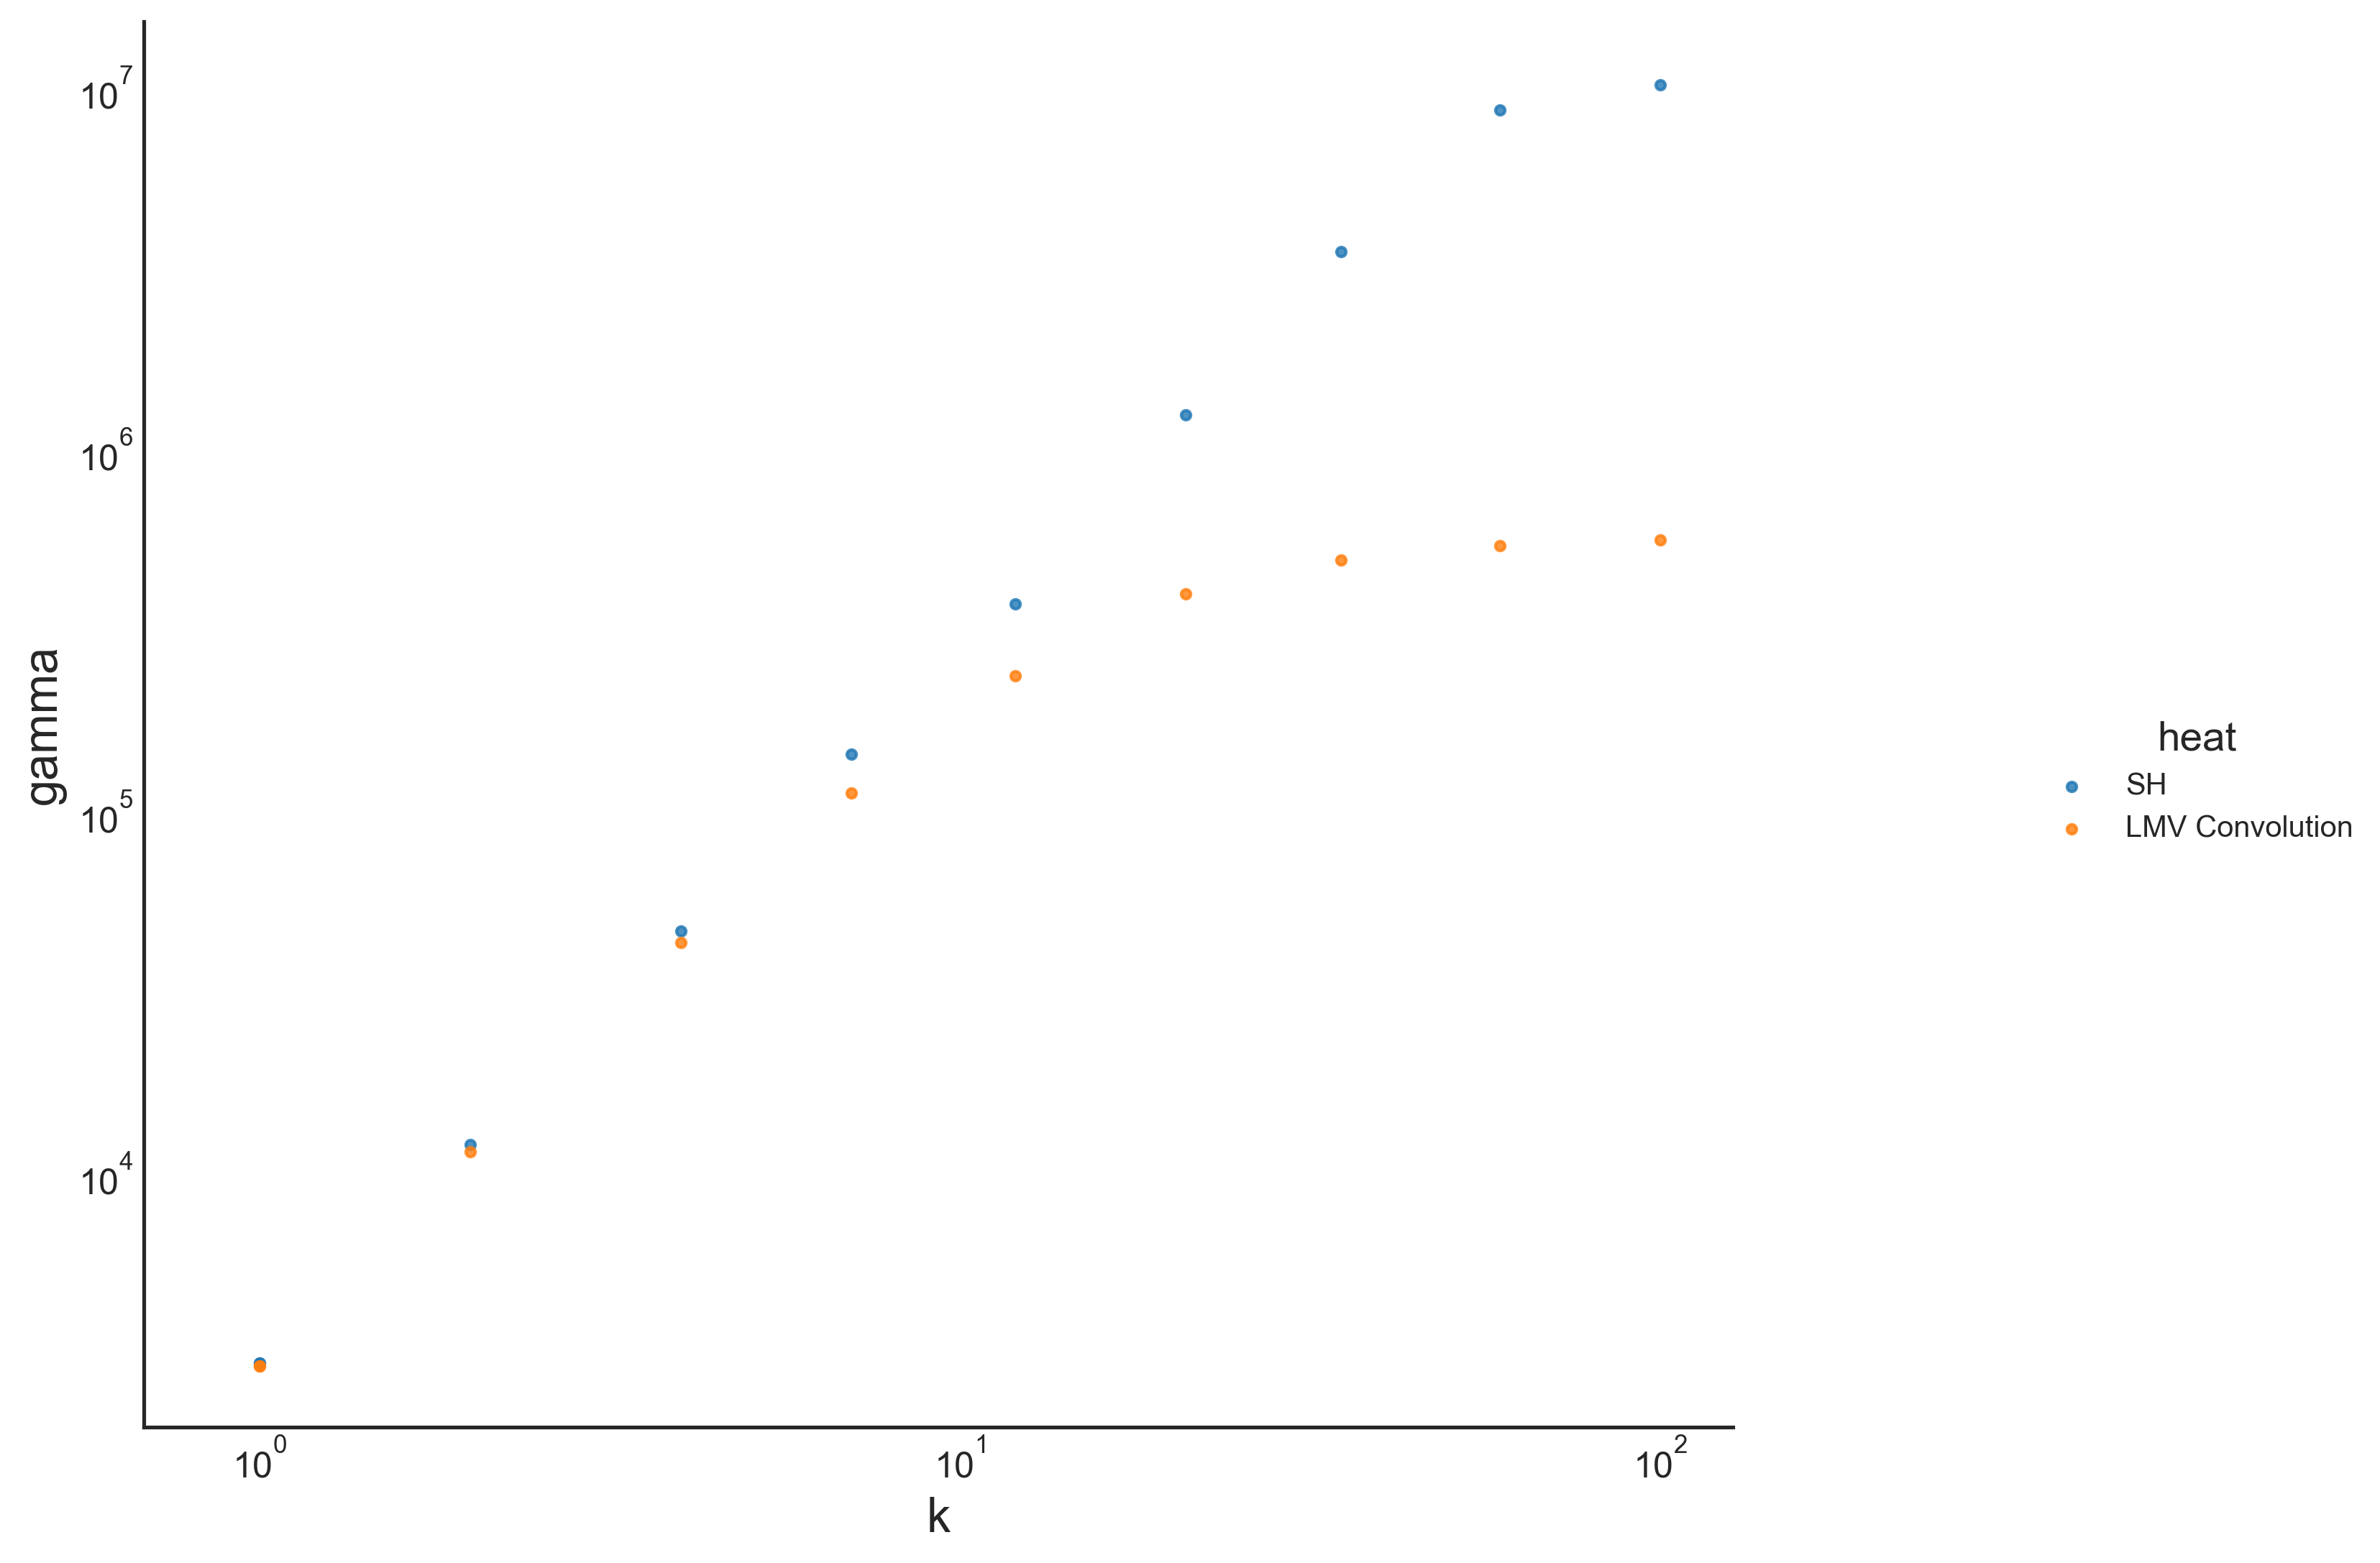

In [8]:
rgb_values = sns.color_palette("Set2", 3)
heat_map = {0:'SH', 1:'Limited', 2:'LMV Convolution'}

df = pd.DataFrame(ret, columns=['k', 'l0', 'l_e', 'T_0','heat', 'gamma', 'gamma_err'])
df['heat'] = df['heat'].map(heat_map)
df['k_le'] = df['k']*df['l_e']

df['gamma_ratio'] = df.apply(lambda x: x['gamma']/list(df['gamma'][(df['heat']=='SH') & (df['k']==x['k'])])[0], axis=1)
df['gamma_ratio_err'] = df.apply(lambda x: np.sqrt((x['gamma_err']/x['gamma'])**2 + ((list(df['gamma_err'][(df['heat']=='SH') & (df['k']==x['k'])])[0])/(list(df['gamma'][(df['heat']=='SH') & (df['k']==x['k'])])[0]))**2), axis=1)

sns.lmplot(data=df, x='k', y='gamma', hue='heat', fit_reg=False, scatter_kws={"s": 10})
plt.xscale('log')
plt.yscale('log')
plt.gcf().set_size_inches(12,8)

[]

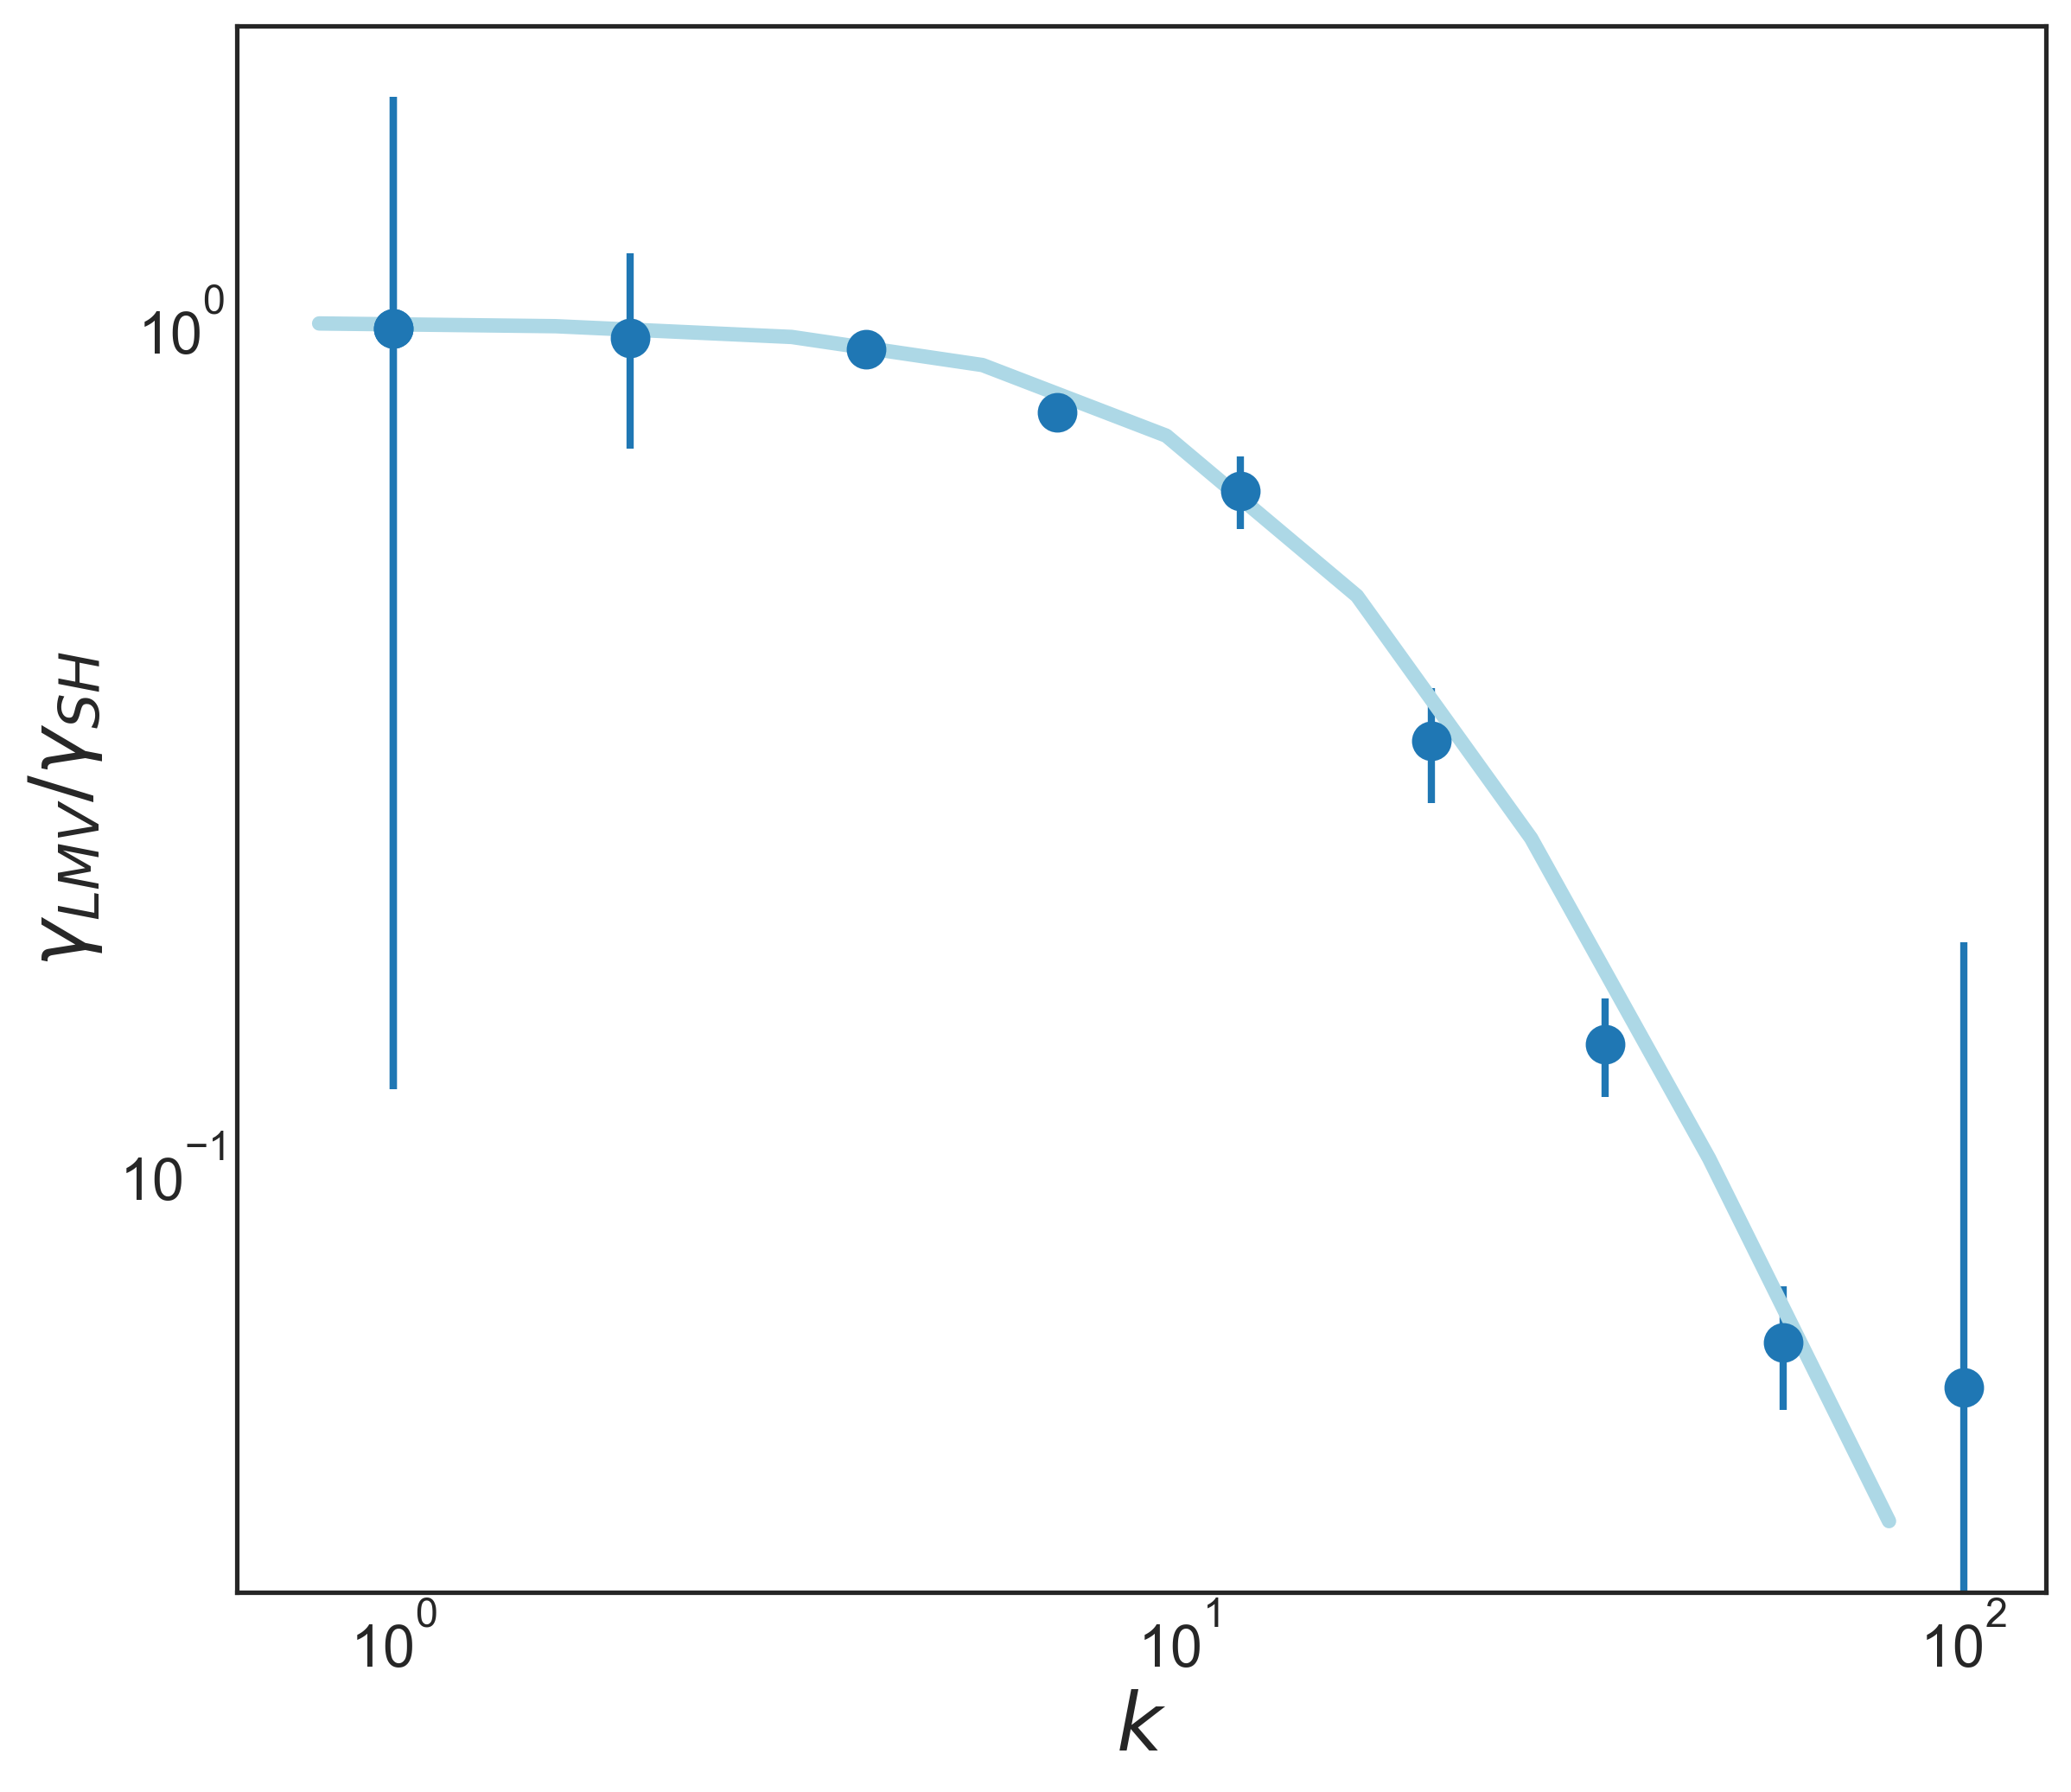

In [12]:
plt.figure(figsize=(9, 8))

data = df[df['heat'] == 'LMV Convolution']

f = (1/20)
plt.errorbar(x=data['k'], y=data['gamma_ratio'], yerr=data['gamma_ratio_err'], fmt='.', ms=20, lw=5, elinewidth=2, )
plt.plot(data['k']*data['l0'], 1/(1+(f*data['k'])**2), '-', lw=4, color='lightblue')

plt.xlabel("$k$", fontsize=22)
plt.ylabel(r"$\gamma_{LMV}/\gamma_{SH}$", fontsize=22)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.loglog()

#plt.savefig("../../thesis/img/ES_plot.pdf")

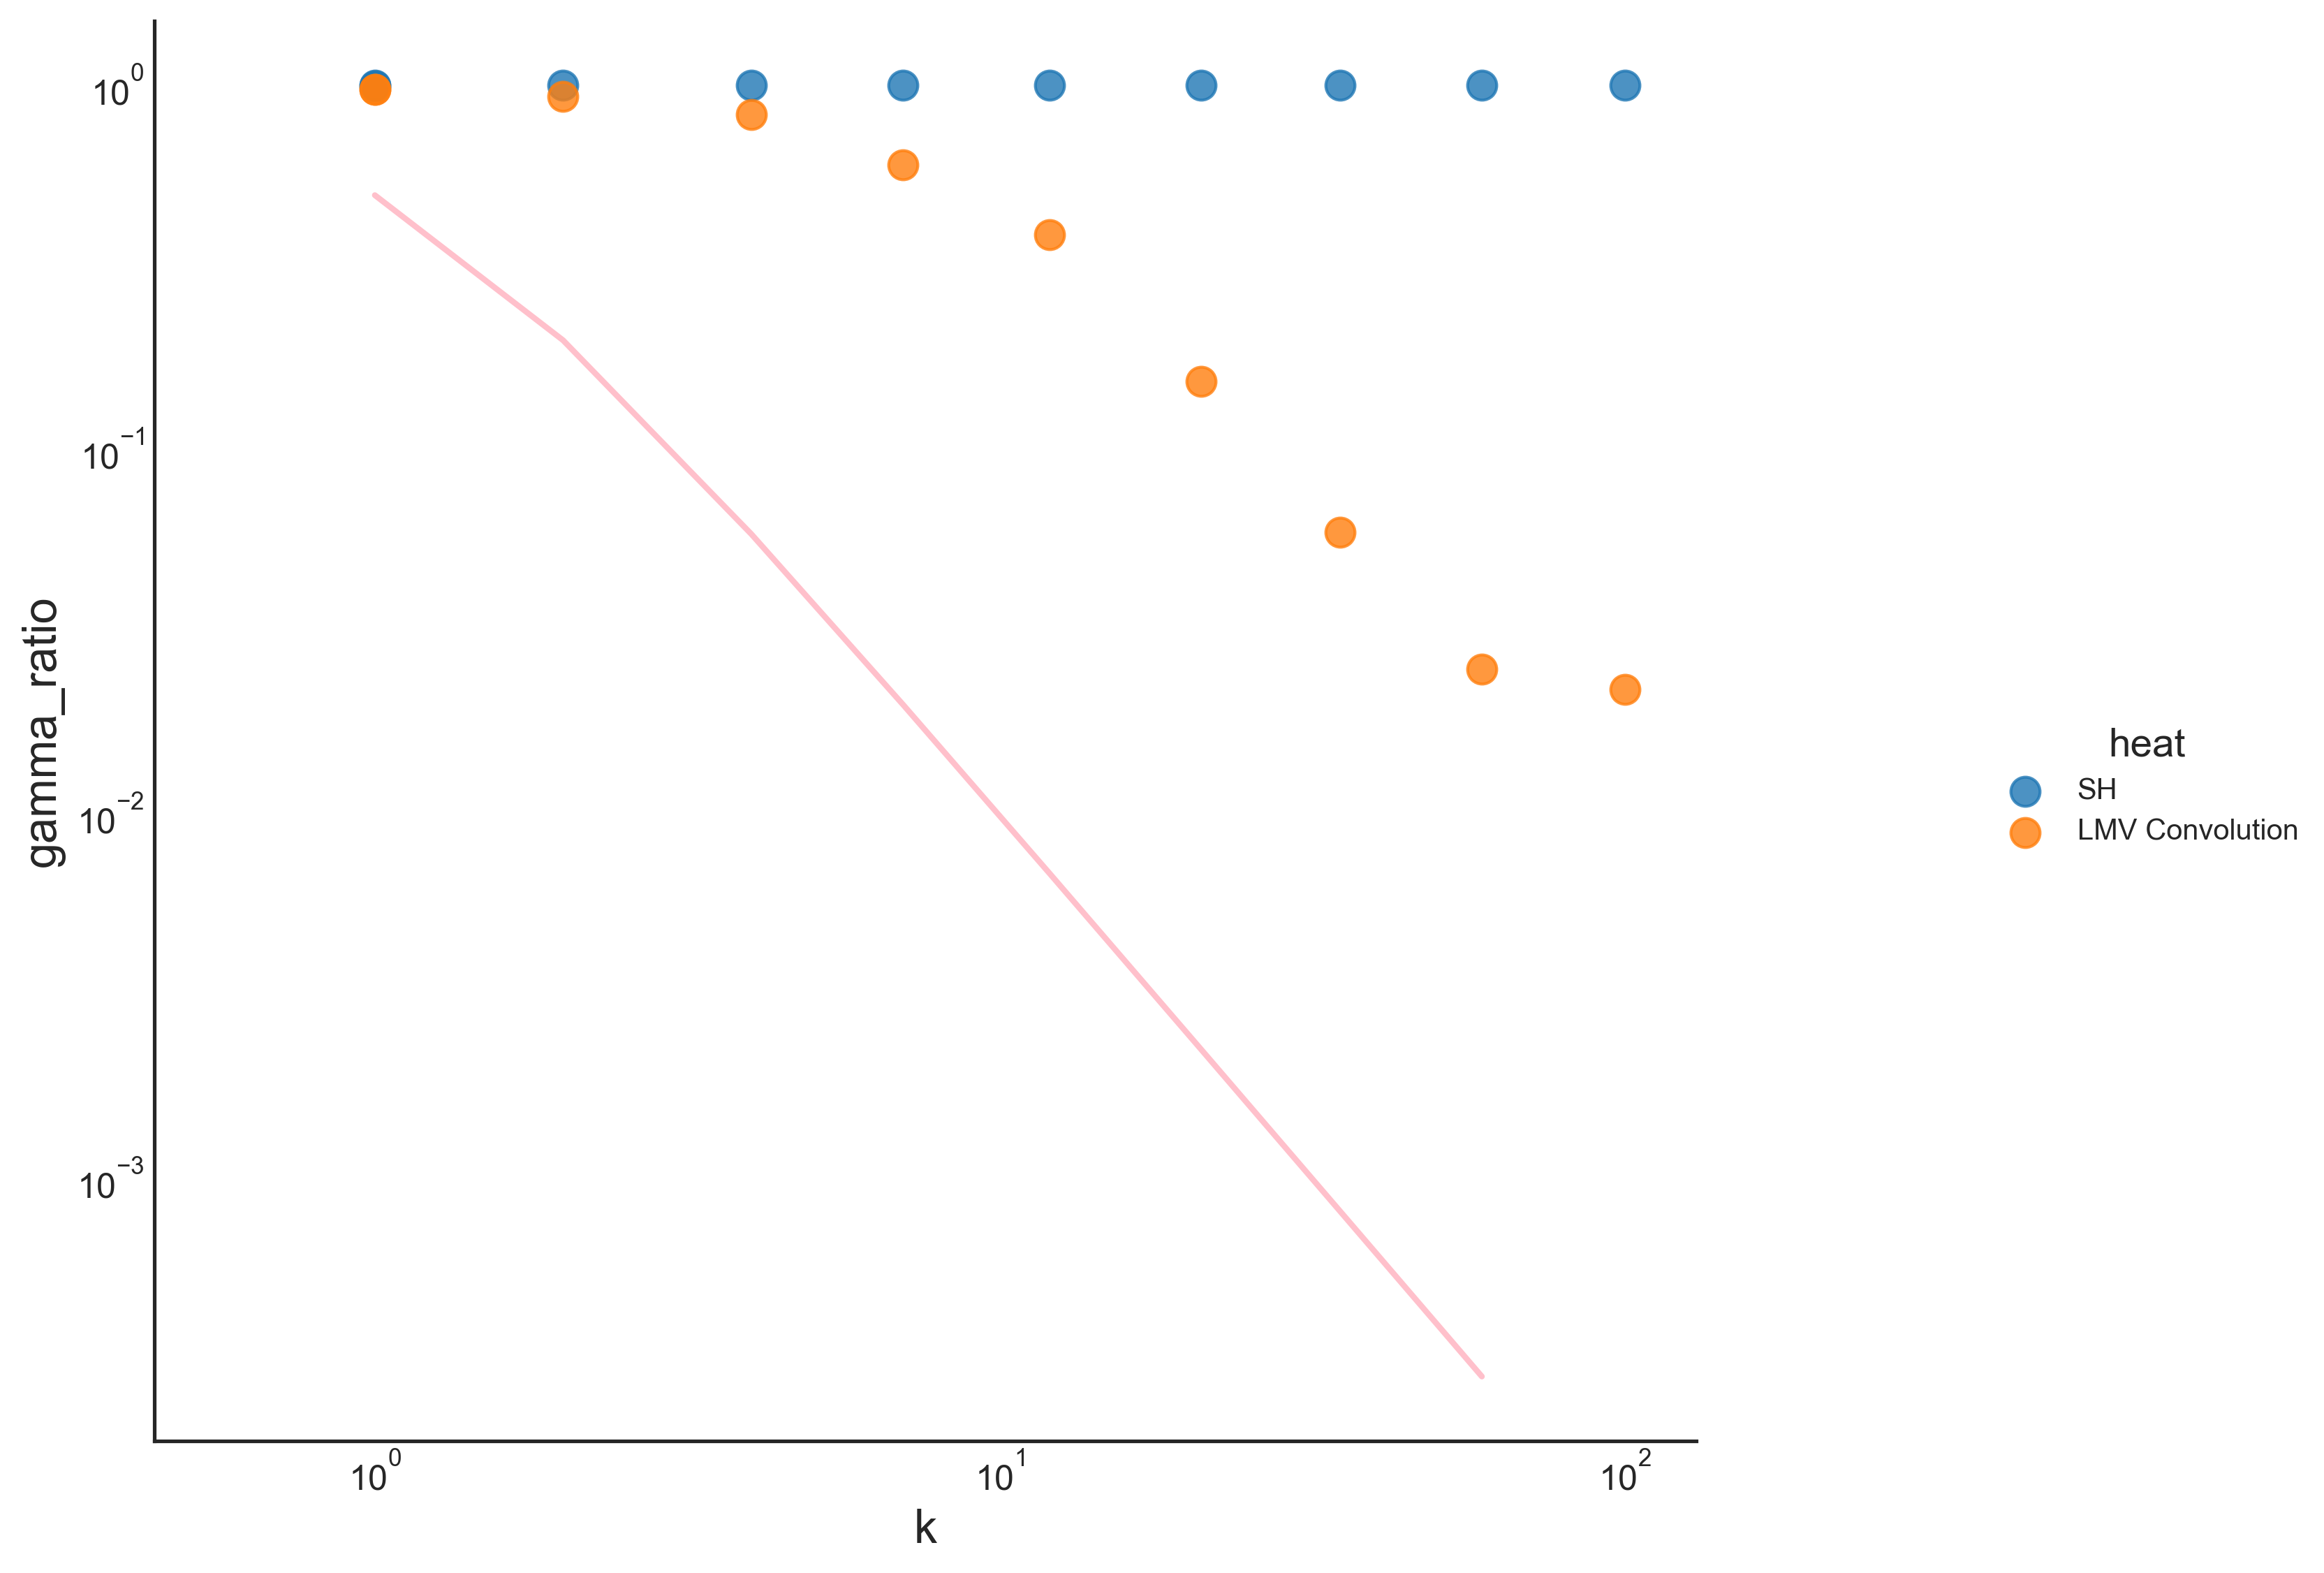

In [96]:
x=df['k'][:9]
a=1

sns.lmplot(data=df, x='k', y='gamma_ratio', hue='heat', fit_reg=False, scatter_kws={"s": 100})
plt.plot(x, 1/(1+(a*x)**2), '-', color='pink')

plt.xscale('log')
plt.yscale('log')
plt.gcf().set_size_inches(12,8)

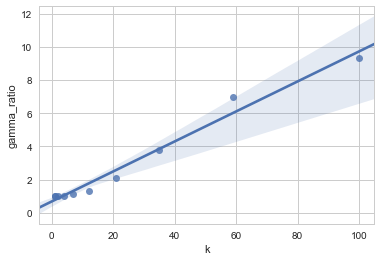

In [105]:
sns.regplot(x=df[df['heat'] =='LMV Convolution']['k'], 
            y=1/df[df['heat'] =='LMV Convolution']['gamma_ratio'])

In [173]:
sl = (slice(0,100, 1), 0, slice(0, None), 0)
interval = 100
p = showdata(collect("T", path='./ny_200/SHConduction_T_t_20_SHConduction_heat_type_2_SHConduction_knorm_True_T_k_100.0/', yguards=False)[sl], interval=interval )
plt.close()
p

mxsub = 1 mysub = 200 mz = 1

nxpe = 1, nype = 1, npe = 1

Reading from ./ny_200/SHConduction_T_t_20_SHConduction_heat_type_2_SHConduction_knorm_True_T_k_100.0/BOUT.dmp.0.nc: [0-0][2-201] -> [0-0][0-199]


In [17]:
sl = (slice(0,100, 1), 0, slice(0, None), 0)
interval = 100
p = showdata(collect("q", path='./ny_200/SHConduction_T_t_20_SHConduction_heat_type_0_SHConduction_knorm_True_T_k_12.0/', yguards=False)[sl], interval=interval )
plt.close()
p

mxsub = 1 mysub = 200 mz = 1

nxpe = 1, nype = 1, npe = 1

Reading from ./ny_200/SHConduction_T_t_20_SHConduction_heat_type_0_SHConduction_knorm_True_T_k_12.0/BOUT.dmp.0.nc: [0-0][2-201] -> [0-0][0-199]


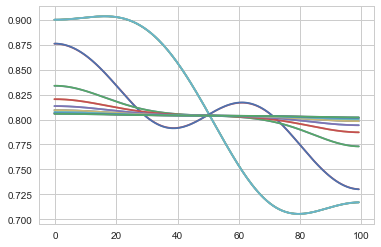

In [22]:
for p in paths:
    l_e = collect("lambda", path=p, yguards=False, info=False)[-1,0,:,0]
    ypos = collect("ypos", path=p, yguards=False, info=False)[0,:,0] - dy
    
    plt.plot(ypos, l_e)

In [172]:
df.to_csv("./ES_data.csv")

In [93]:
df = DataFile(os.path.join(p, "BOUT.dmp.0.nc"))
y = collect("ypos", path=p, yguards=False, info=False)[0,:,0]
T = collect("T", path=p, yguards=False, info=False)[:,0,:,0]
l_e = np.mean(collect("lambda", path=p, yguards=False, info=False)[-1,0,:,0])
opts = BoutOptionsFile(p + "/BOUT.settings")
T_t = df['T_t']

t = dt*np.arange(0,teq(opts['T']['k']*l_e))
log_dT = np.log(np.abs(T[:teq(opts['T']['k']*l_e), 75:125] - T_t)) -  np.log(np.abs(T[0, 75:125] - T_t))
gammas = np.array([-stats.linregress(x=t, y=log_dT[:,i]).slope for i in range(50)])
l = RANSACRegressor()
gammas_RANSAC = np.array([-l.fit(t.reshape(-1, 1), log_dT[:,i:i+1]).estimator_.coef_[0,0] for i in range(50)])

In [77]:
l = RANSACRegressor()


In [94]:
np.nanmean(gammas),np.nanmean(gammas_RANSAC)

(395053.9587586484, 392511.5128678634)

In [92]:
p="./ny_200/SHConduction_T_t_20_SHConduction_heat_type_0_SHConduction_knorm_True_T_k_12.0/"

In [167]:
pwd

'/Users/Daniel/Documents/Imperial/MSciProject/notebooks/EpperleinShort'